# Training and validation

In this notebook, we discuss the configuration file used by `SPINE` to drive a machine-learning algorithm and how they can be used to train (optimize) a neural network and validate its performance on an independant dataset. As a case study, we'll test this out on the *semantic segmentation* task which is performed by a model called *Sparse-UResNet*.

<figure>
<img src="https://edbatista.typepad.com/edbatista/images/2006/02/Full_Metal_Jacket_small.jpg" style="width:400px">
<figcaption align = "center"> You teaching the network to recognize Michel electrons </figcaption>
</figure>

***
***
## I. Configuration file

A configuration file for training/validating are writen using the YAML syntax and consists of three main blocks:
- `io` which specifies how to load and massage data to be fed to the model
- `model` which defines the model to used
- `base` which defines the training/validation process to be executed

Let's look at them sequentially.

In [62]:
import sys

SOFTWARE_DIR = '/n/holyscratch01/iaifi_lab/Users/nsantiago/spine' # Change this path to your software install
DATA_DIR = '/n/holyscratch01/iaifi_lab/Users/nsantiago/inputfiles' # Change this path if you are not on SDF (see main README)

# Set software directory
sys.path.append(SOFTWARE_DIR)

***
### I/O tools

You've just seen this one in the input visualization discussion in the previous notebook, but let's take a quick look again and discuss some considerations when setting parameters for training purposes:

```yaml
io:
  loader:
    batch_size: 128
    shuffle: False
    num_workers: 4
    collate_fn: all
    sampler: random_sequence
    dataset:
      name: larcv
      file_keys: DATA_PATH
      limit_num_files: null
      event_list: null
      skip_event_list: null
      schema:
        input_data:
          parser: sparse3d
          sparse_event: sparse3d_pcluster
        seg_label:
          parser: sparse3d
          sparse_event: sparse3d_pcluster_semantics
```

A few considerations:
- `batch_size` is mostly driven by memory useage. A large `batch_size` reduces stochastic fluctuation batch-to-batch but there's only so many images one can fit on a GPU (along with the gradients that the network computes). This might take some trial and error to figure out how much memory the networks occupies and how many images one can fit before the memory saturates
- `num_workers` specifies the number of CPUs working on data loading. As long as the execution time is mostly driven by the network forward + backward execution, no need to increase that number. Note that increasing the number of CPUs beyond reason will throttle individual processes and diminish the gains in loading speed.
- `sampler` should be randomized using `random_squence` to ensure that images are not always combined in the same way (slows down overtraining). We do not use a purely random sampler because of the IO cost incurred when doing a non-sequential read on a TChain made up of multiple files.
- `dataset` specifies how the data gets loaded, which was covered previously.

***
### Model

This block covers the network configuration and looks like this:

```yaml
model:
  name: uresnet
  weight_path: null

  network_input:
    data: data
  loss_input:
    seg_label: seg_label

  modules:
    uresnet:
      num_input: 1
      num_classes: 5
      filters: 32
      depth: 5
      reps: 2
      allow_bias: false
      activation:
        name: lrelu
        negative_slope: 0.33
      norm_layer:
        name: batch_norm
        eps: 0.0001
        momentum: 0.01

    uresnet_loss:
      balance_loss: false
```

Here are a high level description of what this does:
- `name` specifies the name of the model as defined under [`spine.model.factories`](https://github.com/DeepLearnPhysics/spine/blob/develop/spine/model/factories.py). If you were to check the line with `uresnet`, you'd see this:   `"uresnet": (uresnet.UResNet_Chain, uresnet.SegmentationLoss)`
  - The first item in the list is the PyTorch model description
  - The second item is the PyTorch loss description
  - More detail can be found under [`spine.model.uresnet`](https://github.com/DeepLearnPhysics/spine/blob/develop/spine/model/uresnet.py)
- `weight_path` specifies the path to a set of pretrained weights to load. This is useful in inference mode or if you are picking up the training process from an existing point (e.g. transfer training)
- `modules` contains the list of modules that make up the model. In this case, there is only one, but if one was to look at the full chain, you'd see several.
  - `uresnet` is the name of the network within [`spine.model.uresnet`](https://github.com/DeepLearnPhysics/spine/blob/develop/spine/model/uresnet.py), hence the name of the block. The content of that block provides specific network paramters, e.g. `num_input` for the number of input features (rescaled charge), `num_classes` for the number of target classes, etc.
- `network_input` specifies the input to the network, as defined in the I/O tool block
- `loss_input` specifies the input to the loss function, as defined in the I/O tool block

***
### Base

This block covers the training/validation regimen:

```yaml
# Base configuration
base:
  world_size: 1
  iterations: 10000 # ~128k/128 -> ~1k/epoch -> ~10 epochs
  seed: 0
  unwrap: false
  log_dir: logs/uresnet
  log_step: 1
  overwrite_log: true
  train:
    weight_prefix: weights/uresnet/snapshot
    save_step: 1000 # ~1 epoch
    optimizer:
      name: Adam
      lr: 0.001
```

A lot of intersting things to see here. First the driver specifications:
- `world_size`: This specifies the number of GPUs visible to the model
  - If you set it to `0`, the model will execute on CPU (very slow)
  - If you set it to `n >= 1`, it will execute the model using n GPUs (backend: torch's `DistributedDataParallel`, or DDP for short for n >= 2)
- `iterations`: Number of iterations to run. This number should be sufficient to get to the best set of weights, without overtaining the network (waste of time and resources). This takes some experience to figure out but ~25 epochs is a good target with this dataset, when training from scratch.
- `seed`: Random seed used. If you use the same seed, you should get identical results. This is particularly useful when trying to debug something to know that you're looking at the same batch of images at the same iteration!
- `unwrap`: Whether or not to break down the input/output of the network image-wise within a batch. This is useful for visualization/storage, but useless during traing, so it should be kept `False` to save time
- `log_dir`: Path to the log directory where the training loss/accuracy/etc. will be stored
- `log_step`: How often to store the training loss/accuracy and other parameters of interest during training (here at every iteration)
- `overwrite_log`: If `False`, the driver will throw if the log already exists (can prevent accidental overwrite of large useful training log)

Within it lives the `train` block (which you can simply remove when running inference mode), which specifies:
- `weight_prefix`: where to store the weights, i.e. the optimized parameters of the network
- `save_step`: How often to store the network weights. You don't wanna do that too often to limit the disk useage (a weightfile for this network is ~ 80 MB), but you also want some level of granularity for the validation process. Also note that if the process crashes, for whatever reason, having relatively recent weights helps picking up where you left off quicker. Here I picked to store every 1 epoch.
- `optimizer`: Name of the PyTorch optimizer to use (any algorithm existing [here](https://pytorch.org/docs/stable/optim.html), here [Adam](https://optimization.cbe.cornell.edu/index.php?title=Adam#:~:text=Adam%20optimizer%20is%20the%20extended,processing%20in%20the%20future%20years.)

***
***
## II. Running training

To start a training process, once you're armed with your config, it's a piece of cake. Log into SDF and then there's two options. You can use `srun` to submit a job to slurm directly like so:

***
### SLURM's srun

```shell
srun --account=neutrino --partition=ampere --job-name=train_uresnet --output=log.out --error=log.err --ntasks=1 --cpus-per-task=5 --mem-per-cpu=4g --time=6:00:00 --gpus a100:1 singularity exec --bind /sdf/group/neutrino/drielsma/,/sdf/data/neutrino/ --nv /sdf/group/neutrino/images/develop.sif bash -c "python3 /sdf/data/neutrino/software/spine/bin/run.py -c /sdf/group/neutrino/drielsma/train/example/uresnet.cfg" &
```

A lot to see here. Let's start with the `srun` options:
- `account`: account to run on
  - `neutrino` has dedicated GPUs, but be a good citizen and don't abuse resources!
  - Should provide a `repo` for accounting reasons:
    - `neutrino:icarus-ml` (SBN), `neutrino:dune-ml` (2x2, DUNE-ND)
- `partition`: On S3DF, specifies the GPU class (e.g. `ampere`). To visualize available resources, one can do `sinfo -all`:
  - Options: `ampere` or `turing` (GPUs), `milano` (CPU only)
- `job-name`: how the job appears in squeue, e.g.
```shell
$ squeue | grep drielsma
           9176141        ml train_ur drielsma  R      22:53      1 sdfampere008
```
- `output`: file in which to store the output of stdout
- `ntasks`: number of processes to run (1)
- `cpus-per-task`: how many CPU cores are needed (here just 1 per data loader + the main process)
- `mem-per-cpu`: RAM per CPU (here 20 GB total for the whole process)
- `time`: Execution time (this model takes ~4.5 hours to train from scratch on an A100 **on this dataset** + some headroom)
- `gpus`: What and how many GPU to request (here 1 A100, the best GPU available on SDF/S3DF)
- `error`: file in which to store the output of stderr (can be the same as `output`)

As for the command, let's break it down:
```shell
singularity exec --bind /sdf/group/neutrino/drielsma/,/sdf/data/neutrino/generic/ --nv /sdf/group/neutrino/images/develop.sif bash -c "python3 /sdf/data/neutrino/software/spine/bin/run.py -c /sdf/group/neutrino/drielsma/train/example/uresnet.cfg" &
```

`singularity` is similar to docker, it loads an image file (`.sif`) which contains all the necessary dependencies so *noone has to build 100 packages locally*:
- `exec`: executes a command within the singularity
- `--bind`: binds specific directories necessary to the training. Here one directory contains the code and the training configuration, while the other contains the datafiles
- `--nv`: sets up the environment to use an Nvidia GPU
- `bash -c`: runs a command in a bash shell
- `python3 ...`: actual training command
  - `/sdf/group/neutrino/drielsma/lartpc_mlreco3d/bin/run.py` is the `lartpc_mlreco3d` executable
  - `/sdf/group/neutrino/drielsma/train/icarus/localized/uresnet.cfg` is the configuration
- `&`: detach it from the window

To see what options the `run.py` script can make, you can use the help argument:

In [63]:
!python3 {SOFTWARE_DIR}bin/run.py -h

python3: can't open file '/n/holyscratch01/iaifi_lab/Users/nsantiago/spinebin/run.py': [Errno 2] No such file or directory


***
### SLURM's sbatch

Another approach is to create a sbatch file, let's say `train_uresnet.sh`, which looks like this:

```bash
#!/bin/bash 

#SBATCH --account=shared
#SBATCH --partition=shared

#SBATCH --job-name=train_uresnet
#SBATCH --output=log.out
#SBATCH --error=log.err

#SBATCH --ntasks=1
#SBATCH --cpus-per-task=5
#SBATCH --mem-per-cpu=4g
#SBATCH --time=48:00:00 
#SBATCH --gpus a100:1

singularity exec --bind /sdf/group/neutrino/drielsma/,/sdf/data/neutrino/generic/ --nv /sdf/group/neutrino/images/develop.sif bash -c "python3 /sdf/group/neutrino/drielsma/spine/bin/run.py /sdf/group/neutrino/drielsma/train/icarus/localized/uresnet.cfg"
```

Which you can run simply by doing
```
sbatch train_uresnet.sh
```
(this is my personal preferred option to keep a record of how I execute training regiments).

***
### SLURM's scancel

To kill a job, simply find out its ID using squeue:

```shell
$ squeue | grep drielsma
           9176141        ml train_ur drielsma  R      22:53      1 sdfampere008
```
and then kill using the process ID
```shell
$ scancel 9176141
```
done!

***
***
## III. Visualizing training

Now let's take a look at what the training log looks like. It's a CSV file so we can load it up easily with Pandas:

In [64]:
import pandas as pd

path = '/n/holyscratch01/iaifi_lab/Users/nsantiago/logs//grappa/train_log-0000000.csv' # Adapt path name
df = pd.read_csv(path)
df

,iter,epoch,first_entry,cpu_mem,cpu_mem_perc,gpu_mem,gpu_mem_perc,iteration_time,iteration_time_cpu,iteration_time_sum,...,model_backward_time_sum_cpu,model_save_time,model_save_time_cpu,model_save_time_sum,model_save_time_sum_cpu,edge_accuracy,edge_loss,edge_count,loss,accuracy
0,0,0.000960,14277,32.517022,6.8,0.012963,0.061911,7.580515,3.817495,7.580515,...,0.022744,0.000005,0.000005,0.000005,0.000005,0.326531,0.803298,588,0.803298,0.326531
1,1,0.001919,4741,32.517308,6.8,0.013825,0.066028,0.194191,0.169580,7.774706,...,0.030907,0.000005,0.000005,0.000011,0.000011,0.352740,0.783251,584,0.783251,0.352740
2,2,0.002879,6245,32.518849,6.8,0.013825,0.066028,0.153370,0.138818,7.928076,...,0.038654,0.000005,0.000005,0.000016,0.000016,0.431111,0.727375,450,0.727375,0.431111
3,3,0.003839,19013,32.518873,6.8,0.013825,0.066028,0.196694,0.180530,8.124770,...,0.046737,0.000005,0.000005,0.000021,0.000021,0.436567,0.704608,536,0.704608,0.436567
4,4,0.004798,2565,32.519418,6.8,0.013825,0.066028,0.182174,0.145687,8.306945,...,0.054325,0.000005,0.000005,0.000026,0.000026,0.488000,0.689108,500,0.689108,0.488000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4163,4163,3.996161,17893,34.787549,7.2,0.021354,0.101987,0.152580,0.151650,682.930667,...,33.151569,0.000005,0.000005,0.894751,0.843294,0.988722,0.065331,532,0.065331,0.988722
4164,4164,3.997121,32837,34.789097,7.2,0.021354,0.101987,0.139812,0.138942,683.070479,...,33.159214,0.000006,0.000006,0.894757,0.843300,0.993243,0.018156,444,0.018156,0.993243
4165,4165,3.998081,453,34.790728,7.2,0.021354,0.101987,0.170961,0.169920,683.241440,...,33.167342,0.000005,0.000005,0.894762,0.843305,0.996825,0.006425,630,0.006425,0.996825
4166,4166,3.999040,17381,34.792047,7.2,0.021354,0.101987,0.145103,0.144213,683.386543,...,33.174954,0.000005,0.000005,0.894767,0.843310,0.994024,0.010021,502,0.010021,0.994024


Let's take look at the keys, specifically:

In [65]:
df.keys()

Index(['iter', 'epoch', 'first_entry', 'cpu_mem', 'cpu_mem_perc', 'gpu_mem',
       'gpu_mem_perc', 'iteration_time', 'iteration_time_cpu',
       'iteration_time_sum', 'iteration_time_sum_cpu', 'load_time',
       'load_time_cpu', 'load_time_sum', 'load_time_sum_cpu', 'model_time',
       'model_time_cpu', 'model_time_sum', 'model_time_sum_cpu',
       'model_forward_time', 'model_forward_time_cpu',
       'model_forward_time_sum', 'model_forward_time_sum_cpu',
       'model_backward_time', 'model_backward_time_cpu',
       'model_backward_time_sum', 'model_backward_time_sum_cpu',
       'model_save_time', 'model_save_time_cpu', 'model_save_time_sum',
       'model_save_time_sum_cpu', 'edge_accuracy', 'edge_loss', 'edge_count',
       'loss', 'accuracy'],
      dtype='object')

Some good stuff in here. Let's take a look at the time/memory profiling tools available to us:
- `iter`: iteration count
- `first_emtry`: entry number in the input file of the first image in the batch
- `epoch`: epoch count, i.e. `iteration`*`batch_size`/`dataset_size`
- `iteration_time`: time to complete the iteration
- `iteration_time_sum`: total execution time since the training began
- `load_time`: time spent on I/O
- `load_time_sum`: time spent on I/O since the training began
- `model_forward_time`: time spent during the network forward function
- `model_backward_time`: CPU time spent during the network backward process
- `model_save_time`: time spent on saving the model weights (only when checkpointing!)
- `gpu_mem`: GPU memory usage

Let's take a look at iteration time and how I/O contibutes

<AxesSubplot: xlabel='iter'>

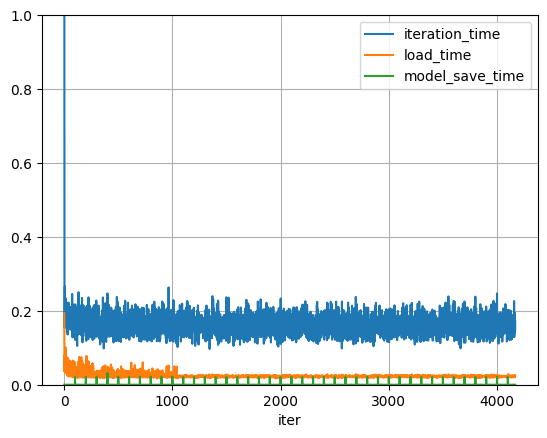

In [66]:
df.plot('iter', ['iteration_time', 'load_time', 'model_save_time'], ylim=[0,1.0], grid=True)

you can see that the training time dominates the execution time, which is what we like to see!

Let's also take a look at our memory consumption over time:

<AxesSubplot: xlabel='iter'>

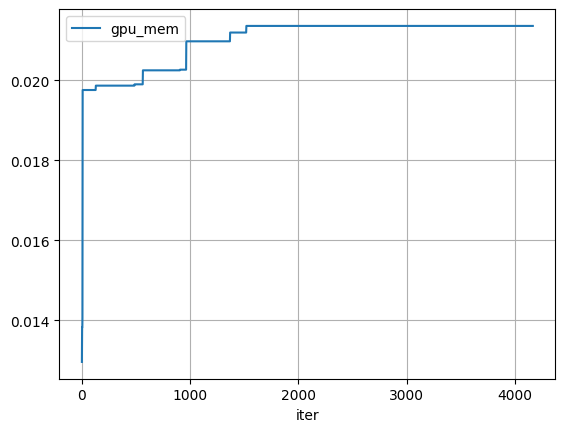

In [67]:
df.plot('iter', 'gpu_mem', grid=True)

you can see that the consumption quickly increases to 10 GB and saturates there (memory is not released once it's claimed). We could probably fit a larger batch (the A100 has 40 GB of RAM), but it's good to keep some headroom.

Now let's check what else is there to look at:
- `accuracy`: Global pixel-wise accuracy of the UResNet-PPN output
- `loss`: Cross-entropy loss for all classes
- `accuracy_class_*`: Pixel-wise accuracy for each of the 5 classes (0: shower, 1: track, 2: Michel, 3: delta, 4: LE scatter)

First, lay thine eyes upon the loss and see that it is decreasing:

<AxesSubplot: xlabel='iter'>

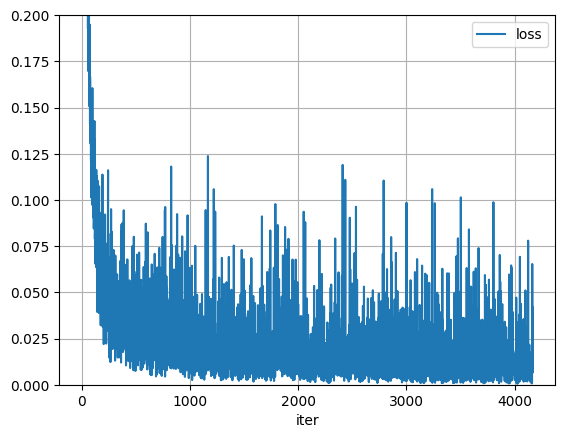

In [68]:
df.plot('iter', 'loss', ylim=[0,0.2], grid=True)

Nice. Now let's check the accuracies:

<AxesSubplot: xlabel='iter'>

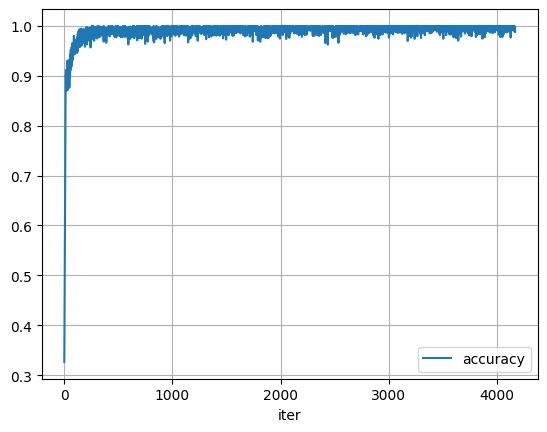

In [69]:
df.plot('iter', ['accuracy'], grid=True)

This is as far as we can go with this log file. Note that a plotting tool exists as part of `SPINE` to visualize the training. You do not have to use it but it simplifies things when e.g.
- Your training is broken up into multiple log files (start/stop training)
- You want to draw multiple model performance (separate training)
- You want an interactive plot

Let's setup the environment and take a quick look at how to use it

In [70]:
import sys

SOFTWARE_DIR = '/n/holyscratch01/iaifi_lab/Users/nsantiago/spine' # Update if needed

# set software directory
sys.path.insert(0, SOFTWARE_DIR)

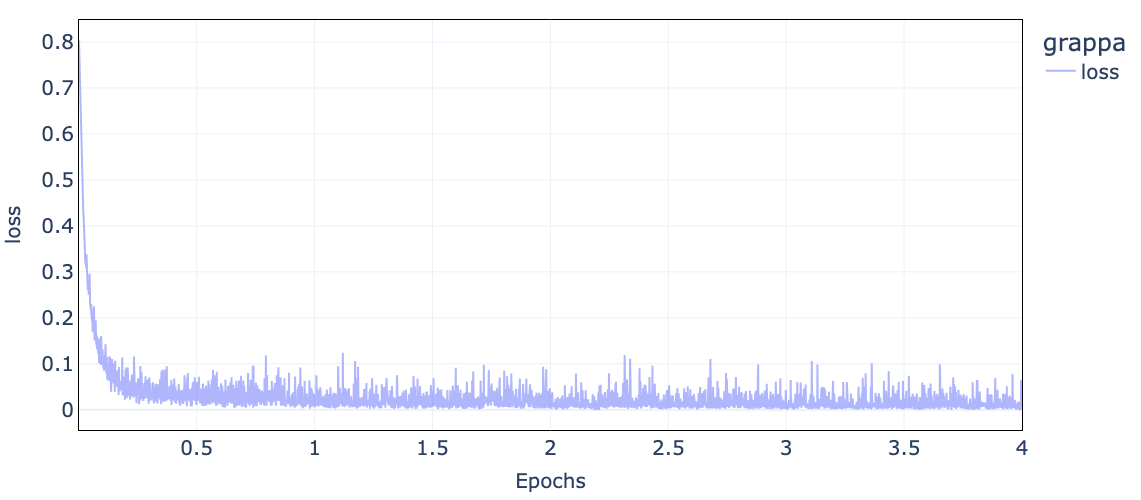

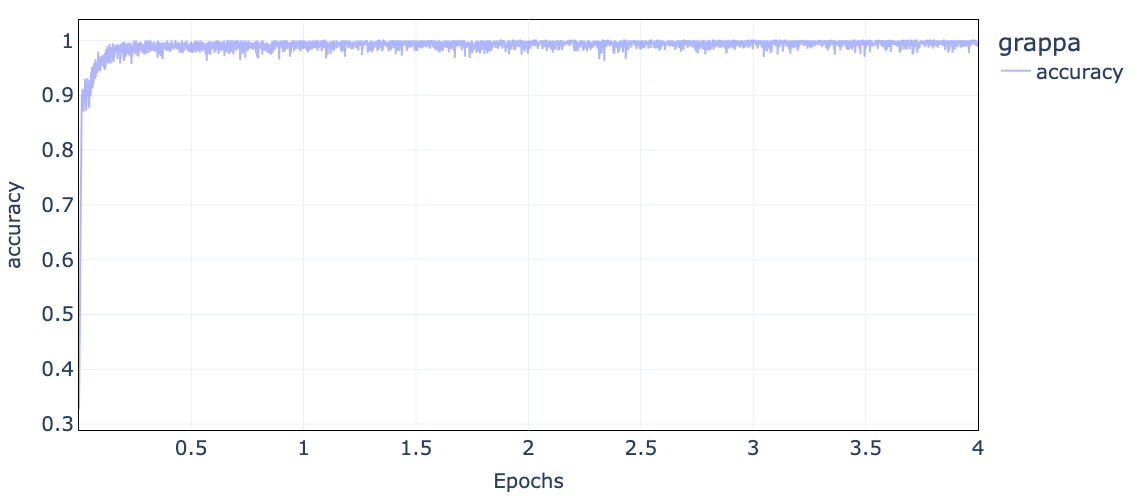

In [71]:
from spine.vis.train import TrainDrawer

log_dir = '/n/holyscratch01/iaifi_lab/Users/nsantiago/logs/'
drawer = TrainDrawer(log_dir, interactive=True, val_prefix=None)


drawer.draw(model='grappa',
            metric='loss')

drawer.draw(model='grappa',
            metric=['accuracy'])

For more options:

In [72]:
help(drawer.draw)

Help on method draw in module spine.vis.train:

draw(model, metric, limits=None, model_name=None, metric_name=None, max_iter=None, step=None, smoothing=None, iter_per_epoch=None, print_min=False, print_max=False, same_plot=True, leg_ncols=1, figure_name=None) method of spine.vis.train.TrainDrawer instance
    Finds all training and validation log files inside the specified
    directory and draws an evolution plot of the requested quantities.
    
    Parameters
    ----------
    model : Union[str, List[str]]
        Model (folder) / list of models names under the main directory
    metric : Union[str, List[str]]
        Metric / list of metrics to draw
    limits : Union[List[float], Dict[str, List[float]]], optional
        List of y boundaries for the plot. If specified as a dictionary,
        can be used to specify different boundaries for each metric.
    model_name : Union[str, Dict[str, str]], optional
        Name of the model as displayed in the legend. If there are multiple

***
***
## IV. Running validation

It is crucial to keep a close eye on a training process after it has been started:
- Training can take of order days to converge, so identifying issues early is a signifcant time and resource saver
- Models can overfit the data if given enough time, monitoring the performance on an intendependant (validation) set is essential to assess it

<figure>
<img src="https://miro.medium.com/max/1125/1*_7OPgojau8hkiPUiHoGK_w.png" style="width:800px">
<figcaption align = "center"> Don't overfit! </figcaption>
</figure>

First, we need a validation configuration. As you can imagine, it is very similar to the train configuration, with a few key changes:
- Remove the `sampler` block from the `loader` block: 
  - For validation, we want to check the performance at each checkpoint without any variations in the validation sample, so that variations in performance stricly represent differences in weight quality
- Change the `file_keys` in the `loader` block from a training set to a validation dataset
  - They need to be independant, that's the whole point!
- Change the total number of `iterations` to a lower value, at most the size of the validation set
- Point `weight_path` in the `model` block to the list model weights you've stored:
  - E.g. /sdf/group/neutrino/drielsma/train/example/weights/uresnet/snapshot*
- Delete the `train` block entirely (inference mode)

Now you're ready to rock and roll. If you call your new config `uresnet_val.cfg`, simply call
```shell
python3 bin/run.py -c uresnet_val.cfg
```
preferably in the `sbatch` script or `srun` command!

What you get as a result is the following:

In [73]:
!ls logs/uresnet/

inference_log-0001000.csv  inference_log-0010000.csv  inference_log-0019000.csv
inference_log-0002000.csv  inference_log-0011000.csv  inference_log-0020000.csv
inference_log-0003000.csv  inference_log-0012000.csv  inference_log-0021000.csv
inference_log-0004000.csv  inference_log-0013000.csv  inference_log-0022000.csv
inference_log-0005000.csv  inference_log-0014000.csv  inference_log-0023000.csv
inference_log-0006000.csv  inference_log-0015000.csv  inference_log-0024000.csv
inference_log-0007000.csv  inference_log-0016000.csv  inference_log-0025000.csv
inference_log-0008000.csv  inference_log-0017000.csv  train_log-0000000.csv
inference_log-0009000.csv  inference_log-0018000.csv


For each weight file (every 2000 iterations), you get a log file with 400 entries which has the exact same structure as the train file. Each of these file corresponds to a specific iteration in the training and can validate whether the network performs as well on an independant set, or not!

***
***
## V. Visualization validation

Now let's take a look at the files. One way to this is to loop over the files and average over the quantities you are trying to validate, e.g.:

In [74]:
import pandas as pd

path = '/n/holyscratch01/iaifi_lab/Users/nsantiago/logs/grappa/train_log-0000000.csv'
df = pd.read_csv(path)
df

,iter,epoch,first_entry,cpu_mem,cpu_mem_perc,gpu_mem,gpu_mem_perc,iteration_time,iteration_time_cpu,iteration_time_sum,...,model_backward_time_sum_cpu,model_save_time,model_save_time_cpu,model_save_time_sum,model_save_time_sum_cpu,edge_accuracy,edge_loss,edge_count,loss,accuracy
0,0,0.000960,14277,32.517022,6.8,0.012963,0.061911,7.580515,3.817495,7.580515,...,0.022744,0.000005,0.000005,0.000005,0.000005,0.326531,0.803298,588,0.803298,0.326531
1,1,0.001919,4741,32.517308,6.8,0.013825,0.066028,0.194191,0.169580,7.774706,...,0.030907,0.000005,0.000005,0.000011,0.000011,0.352740,0.783251,584,0.783251,0.352740
2,2,0.002879,6245,32.518849,6.8,0.013825,0.066028,0.153370,0.138818,7.928076,...,0.038654,0.000005,0.000005,0.000016,0.000016,0.431111,0.727375,450,0.727375,0.431111
3,3,0.003839,19013,32.518873,6.8,0.013825,0.066028,0.196694,0.180530,8.124770,...,0.046737,0.000005,0.000005,0.000021,0.000021,0.436567,0.704608,536,0.704608,0.436567
4,4,0.004798,2565,32.519418,6.8,0.013825,0.066028,0.182174,0.145687,8.306945,...,0.054325,0.000005,0.000005,0.000026,0.000026,0.488000,0.689108,500,0.689108,0.488000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4163,4163,3.996161,17893,34.787549,7.2,0.021354,0.101987,0.152580,0.151650,682.930667,...,33.151569,0.000005,0.000005,0.894751,0.843294,0.988722,0.065331,532,0.065331,0.988722
4164,4164,3.997121,32837,34.789097,7.2,0.021354,0.101987,0.139812,0.138942,683.070479,...,33.159214,0.000006,0.000006,0.894757,0.843300,0.993243,0.018156,444,0.018156,0.993243
4165,4165,3.998081,453,34.790728,7.2,0.021354,0.101987,0.170961,0.169920,683.241440,...,33.167342,0.000005,0.000005,0.894762,0.843305,0.996825,0.006425,630,0.006425,0.996825
4166,4166,3.999040,17381,34.792047,7.2,0.021354,0.101987,0.145103,0.144213,683.386543,...,33.174954,0.000005,0.000005,0.894767,0.843310,0.994024,0.010021,502,0.010021,0.994024


<AxesSubplot: xlabel='iter'>

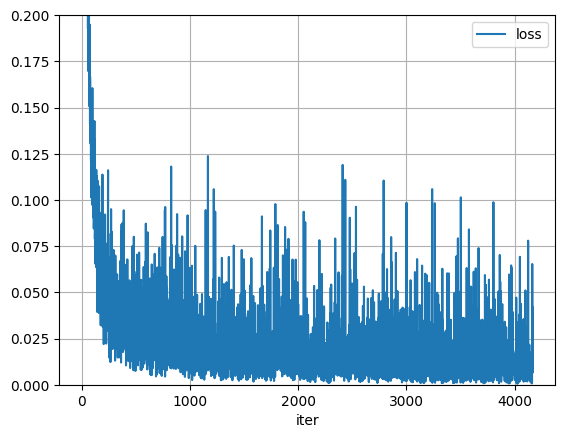

In [75]:
df.plot('iter', 'loss', ylim=[0,0.2], grid=True)

In [76]:
import glob

val_files = glob.glob('/n/holyscratch01/iaifi_lab/Users/nsantiago/logs/grappa/inference_log-*.csv')
print(val_files)

['/n/holyscratch01/iaifi_lab/Users/nsantiago/logs/grappa/inference_log-0000600.csv', '/n/holyscratch01/iaifi_lab/Users/nsantiago/logs/grappa/inference_log-0002700.csv', '/n/holyscratch01/iaifi_lab/Users/nsantiago/logs/grappa/inference_log-0001400.csv', '/n/holyscratch01/iaifi_lab/Users/nsantiago/logs/grappa/inference_log-0002300.csv', '/n/holyscratch01/iaifi_lab/Users/nsantiago/logs/grappa/inference_log-0001800.csv', '/n/holyscratch01/iaifi_lab/Users/nsantiago/logs/grappa/inference_log-0001500.csv', '/n/holyscratch01/iaifi_lab/Users/nsantiago/logs/grappa/inference_log-0001600.csv', '/n/holyscratch01/iaifi_lab/Users/nsantiago/logs/grappa/inference_log-0002400.csv', '/n/holyscratch01/iaifi_lab/Users/nsantiago/logs/grappa/inference_log-0003400.csv', '/n/holyscratch01/iaifi_lab/Users/nsantiago/logs/grappa/inference_log-0000500.csv', '/n/holyscratch01/iaifi_lab/Users/nsantiago/logs/grappa/inference_log-0002600.csv', '/n/holyscratch01/iaifi_lab/Users/nsantiago/logs/grappa/inference_log-00039

In [77]:
iterations = [int(f.split('-')[-1][:7]) for f in val_files]
losses = [pd.read_csv(f).loss.mean() for f in val_files]
stds = [pd.read_csv(f).loss.std() for f in val_files]
print(iterations)
print(losses)

[600, 2700, 1400, 2300, 1800, 1500, 1600, 2400, 3400, 500, 2600, 3900, 3300, 2800, 100, 4000, 900, 3100, 800, 1000, 300, 2900, 1700, 1300, 1900, 3700, 1100, 3000, 3500, 2200, 2500, 400, 2100, 4100, 3200, 3800, 3600, 700, 2000, 1200, 200]
[0.02510795262124799, 0.012423014032717651, 0.014999788967363585, 0.012285652151906148, 0.02578147292844257, 0.016376474181500525, 0.014040468619521199, 0.012724466582495715, 0.012125978550807536, 0.02827022552524723, 0.012323051106966526, 0.010703532014941794, 0.022364484141602275, 0.015299300061981432, 0.10782551371756892, 0.010441854081754697, 0.025779678985292483, 0.011386729120334312, 0.023156566215954945, 0.01800573851056622, 0.034893743321299506, 0.014289075124686834, 0.014926709980059965, 0.017670030437731767, 0.01359978990534454, 0.010285770810097062, 0.01740306527440052, 0.012275037987956752, 0.012145104707343698, 0.015769777342067685, 0.014341328148068927, 0.033077074576997045, 0.013229793515113816, 0.010758721772193239, 0.013507752367841422

<ErrorbarContainer object of 3 artists>

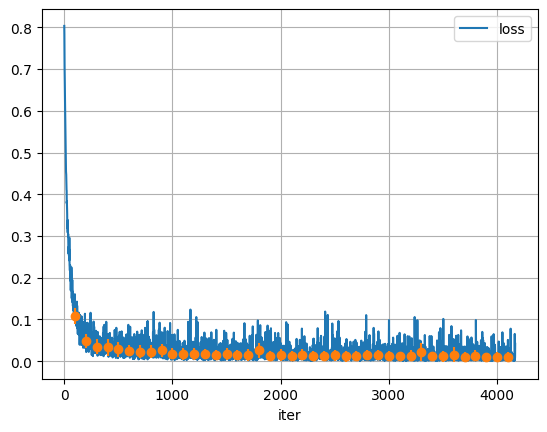

In [78]:
from matplotlib import pyplot as plt

df.plot('iter', 'loss', grid=True)
plt.errorbar(iterations, losses, yerr=stds, fmt='o', label='loss (val)')

In [79]:
help(drawer.draw)

Help on method draw in module spine.vis.train:

draw(model, metric, limits=None, model_name=None, metric_name=None, max_iter=None, step=None, smoothing=None, iter_per_epoch=None, print_min=False, print_max=False, same_plot=True, leg_ncols=1, figure_name=None) method of spine.vis.train.TrainDrawer instance
    Finds all training and validation log files inside the specified
    directory and draws an evolution plot of the requested quantities.
    
    Parameters
    ----------
    model : Union[str, List[str]]
        Model (folder) / list of models names under the main directory
    metric : Union[str, List[str]]
        Metric / list of metrics to draw
    limits : Union[List[float], Dict[str, List[float]]], optional
        List of y boundaries for the plot. If specified as a dictionary,
        can be used to specify different boundaries for each metric.
    model_name : Union[str, Dict[str, str]], optional
        Name of the model as displayed in the legend. If there are multiple

Or... simply use the tools available to you and let the magic happen!

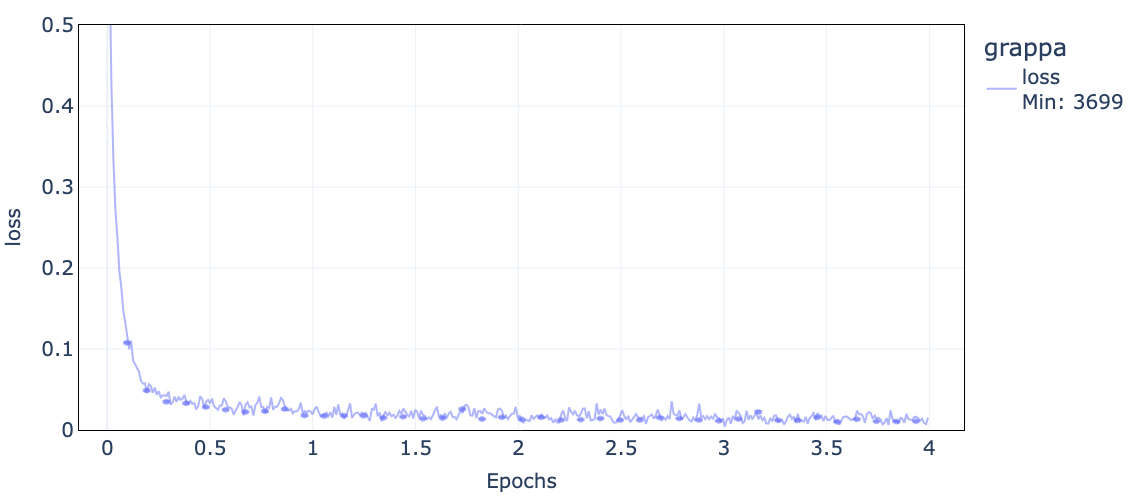

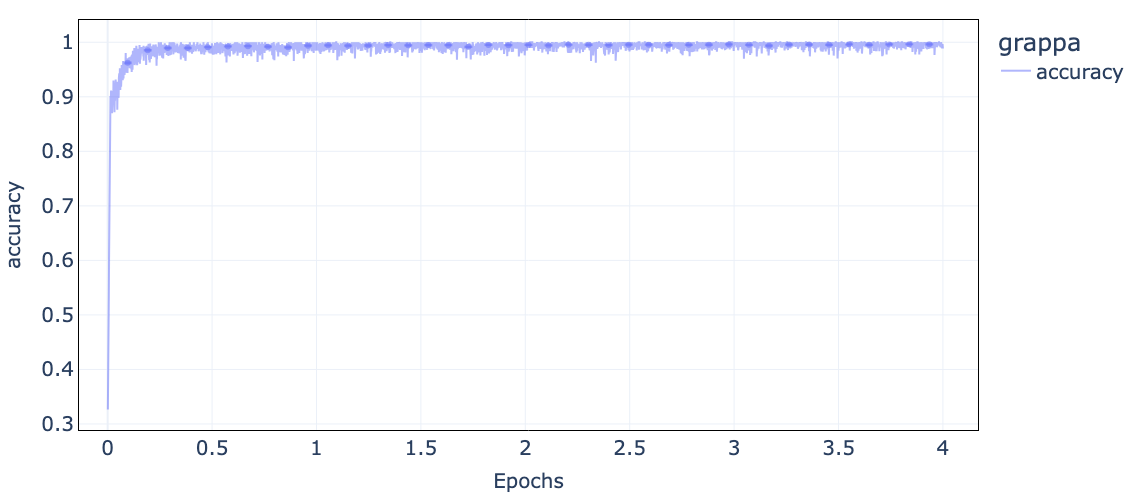

In [80]:
from spine.vis.train import TrainDrawer

log_dir = '/n/holyscratch01/iaifi_lab/Users/nsantiago/logs/'
drawer = TrainDrawer(log_dir, interactive=True)

drawer.draw(model='grappa',
            metric='loss',
           limits=[0.,.5], smoothing=10, step=10, print_min=True)
    
drawer.draw(model='grappa',
            metric=['accuracy'],
           )

In [85]:
import sys

SOFTWARE_DIR = '/n/holyscratch01/iaifi_lab/Users/nsantiago/spine' # Change this path to your software install

# Set software directory
sys.path.append(SOFTWARE_DIR)

In [86]:
from spine.io.read.hdf5 import HDF5Reader

reader = HDF5Reader('/n/holyscratch01/iaifi_lab/Users/nsantiago/spine_workshop_2024/test_output.h5')

Will load 1 file(s):
  - /n/holyscratch01/iaifi_lab/Users/nsantiago/spine_workshop_2024/test_output.h5

Total number of entries in the file(s): 12956

Total number of entries selected: 12956



In [87]:
data = reader[1]

AttributeError: module 'spine' has no attribute 'data'

In [ ]:
from spine.utils.globals import GROUP_COL
from spine.vis.network import network_topology
from spine.vis.layout import HIGH_CONTRAST_COLORS, layout3d

from plotly import graph_objs as go
from plotly.offline import iplot

trace = []

edge_index = data['edge_index'][data['edge_pred'][:, 1] > data['edge_pred'][:, 0]]
edge_index = []
print(edge_index)

trace+= network_topology(data['data'], data['clusts'], edge_index, clust_labels=data['group_pred'], edge_labels=data['edge_pred'],
                       markersize=2, cmin=0, cmax=50, colorscale=HIGH_CONTRAST_COLORS,
                       name='')

fig = go.Figure(data=trace,layout=layout3d(meta=data['meta']))

iplot(fig)

In [ ]:
data['edge_index']

In [ ]:
network_topology

***
***
## VI. Exercises

Here's a few suggestions of things to try out to familirize yourself with the process:
- Train uresnet using the provided configuration file. Modify the file to use the `mpvmpr_mini.root` dataset to speed up the process. Check the number of entries in the file and adapt the number of iterations accordingly! Skip the last 30 entries with the `skip_event_list` parameter to keep them for validation
- Run the validation using the last 30 entries in the file using the `entry_list` parameter
- Try the same process to train grappa_shower (`grappa_shower.cfg` provided) with the `generic_small.root` dataset
- Modify `grappa_shower.cfg` to `grappa_shower_val.cfg` to use for validation
- Visualize all of the above as you go!
- Try this out with your favortite detector! (ICARUS, SBND, 2x2...)